# TODO: need to make sure the LiDAR download code works now
If it's possible, it would be good to consolidate the notebooks and turn things into scripts since we're not editing the network much

## Sample Bridge Decks Using USGS LiDAR (OPTIONAL)
---
Use this notebook to resample bridge deck elevations for specified network links

In [1]:
import geopandas as gpd
import contextily as cx
import pandas as pd
import rasterio
from rasterio.features import geometry_mask
from rasterio.plot import show
import numpy as np
from shapely.geometry import box, mapping
from shapely.ops import Point
from tqdm import tqdm
from shapely.ops import LineString
import pickle

from bikewaysim.paths import config
from bikewaysim.network import elevation_tools

In [2]:
links = gpd.read_file(config['network_fp'] / "osm.gpkg",layer="raw")
links.set_index('osmid',inplace=True)
lidar_urls = elevation_tools.get_lidar_urls(links)
print(len(lidar_urls),'LAZ files for the provided network')
print("Names:",set([lidar_url[1].split('/')[-3] for lidar_url in lidar_urls]))

  0%|                                                                                                                                                            | 0/9 [00:00<?, ?it/s]

 11%|████████████████▍                                                                                                                                   | 1/9 [00:01<00:10,  1.30s/it]

 22%|████████████████████████████████▉                                                                                                                   | 2/9 [00:03<00:12,  1.77s/it]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 3/9 [00:06<00:15,  2.57s/it]

 44%|█████████████████████████████████████████████████████████████████▊                                                                                  | 4/9 [00:08<00:10,  2.00s/it]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                 | 5/9 [00:09<00:07,  1.87s/it]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6/9 [00:13<00:08,  2.70s/it]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 7/9 [00:15<00:04,  2.26s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8/9 [00:16<00:01,  1.99s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  1.80s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.02s/it]

461 LAZ files for the provided network
Names: {'GA_Statewide_B2_2018', 'GA_FULTONCO_2006', 'GA_DEKALBCO_2010', 'GA_Statewide_B3_2018'}


In [3]:
# for the GDOT study area it's GA_Statewide_B2_2018 and GA_Statewide_B3_2018
lidar_urls = [url[1] for url in lidar_urls if 'GA_Statewide' in url[0]]

In [4]:
bridge_decks_fp = config['network_fp']/'bridge_deck_elevations.pkl'

if bridge_decks_fp.exists():
    print("Loading bridge decks from",bridge_decks_fp)
    with open(bridge_decks_fp,'rb') as f:
        bridge_decks = pickle.load(f)
else:
    print("Bridge decks not found, downloading from",lidar_urls)
    # takes about two hours
    bridge_decks = elevation_tools.get_bridge_decks(lidar_urls)
    with open(bridge_decks_fp,'wb') as f:
        pickle.dump([],f)



Loading bridge decks from /Users/tannerpassmore/Documents/BikewaySim/Davis/Network/bridge_deck_elevations.pkl


# Sample Bridges from LiDAR

In [5]:
with (config['network_fp']/'elevation.pkl').open('rb') as fh:
    interpolated_points_dict = pickle.load(fh)
#same dem as text for future reference
with (config['network_fp'] / 'dem_crs.txt').open('r') as file:
    dem_crs = file.read()
bridge_decks.to_crs(dem_crs,inplace=True)

In [6]:
bridge_linkids = links[links['bridge'].notna()].index.tolist()
elevation_tools.sample_lidar(bridge_linkids,interpolated_points_dict,bridge_decks,dem_crs)

  0%|                                                                                                                                                          | 0/249 [00:00<?, ?it/s]

  0%|▌                                                                                                                                                 | 1/249 [00:00<00:43,  5.71it/s]

  1%|█▊                                                                                                                                                | 3/249 [00:00<00:30,  8.13it/s]

  2%|███▌                                                                                                                                              | 6/249 [00:00<00:21, 11.12it/s]

  3%|████▋                                                                                                                                             | 8/249 [00:01<00:44,  5.43it/s]

  4%|█████▎                                                                                                                                            | 9/249 [00:01<00:42,  5.69it/s]

  4%|█████▊                                                                                                                                           | 10/249 [00:01<00:38,  6.14it/s]

  4%|██████▍                                                                                                                                          | 11/249 [00:01<00:49,  4.85it/s]

  5%|██████▉                                                                                                                                          | 12/249 [00:02<00:46,  5.09it/s]

  5%|███████▌                                                                                                                                         | 13/249 [00:02<00:43,  5.36it/s]

  6%|█████████▎                                                                                                                                       | 16/249 [00:03<00:53,  4.38it/s]

  7%|██████████▍                                                                                                                                      | 18/249 [00:03<00:42,  5.41it/s]

  8%|███████████                                                                                                                                      | 19/249 [00:03<00:53,  4.26it/s]

  8%|███████████▋                                                                                                                                     | 20/249 [00:04<01:03,  3.62it/s]

  9%|████████████▊                                                                                                                                    | 22/249 [00:04<01:00,  3.76it/s]

 10%|█████████████▉                                                                                                                                   | 24/249 [00:04<00:45,  4.92it/s]

 10%|██████████████▌                                                                                                                                  | 25/249 [00:05<00:58,  3.80it/s]

 10%|███████████████▏                                                                                                                                 | 26/249 [00:05<00:50,  4.40it/s]

 11%|████████████████▎                                                                                                                                | 28/249 [00:05<00:39,  5.61it/s]

 12%|████████████████▉                                                                                                                                | 29/249 [00:05<00:37,  5.80it/s]

 12%|█████████████████▍                                                                                                                               | 30/249 [00:05<00:37,  5.89it/s]

 13%|██████████████████▋                                                                                                                              | 32/249 [00:06<00:28,  7.60it/s]

 13%|███████████████████▏                                                                                                                             | 33/249 [00:06<00:28,  7.50it/s]

 14%|███████████████████▊                                                                                                                             | 34/249 [00:06<00:29,  7.36it/s]

 14%|████████████████████▍                                                                                                                            | 35/249 [00:06<00:36,  5.91it/s]

 14%|████████████████████▉                                                                                                                            | 36/249 [00:06<00:36,  5.90it/s]

 15%|█████████████████████▌                                                                                                                           | 37/249 [00:06<00:36,  5.80it/s]

 15%|██████████████████████▏                                                                                                                          | 38/249 [00:07<00:32,  6.52it/s]

 16%|██████████████████████▋                                                                                                                          | 39/249 [00:07<00:42,  4.99it/s]

 16%|███████████████████████▉                                                                                                                         | 41/249 [00:07<00:31,  6.57it/s]

 17%|████████████████████████▍                                                                                                                        | 42/249 [00:07<00:39,  5.25it/s]

 18%|█████████████████████████▌                                                                                                                       | 44/249 [00:07<00:29,  6.85it/s]

 18%|██████████████████████████▊                                                                                                                      | 46/249 [00:08<00:24,  8.32it/s]

 19%|███████████████████████████▎                                                                                                                     | 47/249 [00:08<00:26,  7.49it/s]

 20%|████████████████████████████▌                                                                                                                    | 49/249 [00:08<00:24,  8.27it/s]

 20%|█████████████████████████████                                                                                                                    | 50/249 [00:08<00:26,  7.61it/s]

 20%|█████████████████████████████▋                                                                                                                   | 51/249 [00:09<00:37,  5.31it/s]

 21%|██████████████████████████████▊                                                                                                                  | 53/249 [00:09<00:27,  7.18it/s]

 22%|████████████████████████████████▌                                                                                                                | 56/249 [00:09<00:18, 10.32it/s]

 23%|█████████████████████████████████▊                                                                                                               | 58/249 [00:09<00:23,  8.29it/s]

 24%|██████████████████████████████████▉                                                                                                              | 60/249 [00:09<00:20,  9.22it/s]

 25%|████████████████████████████████████                                                                                                             | 62/249 [00:09<00:17, 10.56it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 64/249 [00:10<00:17, 10.62it/s]

 27%|██████████████████████████████████████▍                                                                                                          | 66/249 [00:10<00:16, 11.39it/s]

 29%|██████████████████████████████████████████▌                                                                                                      | 73/249 [00:10<00:09, 19.14it/s]

 31%|████████████████████████████████████████████▎                                                                                                    | 76/249 [00:10<00:08, 20.05it/s]

 32%|██████████████████████████████████████████████                                                                                                   | 79/249 [00:12<00:27,  6.12it/s]

 33%|███████████████████████████████████████████████▏                                                                                                 | 81/249 [00:12<00:31,  5.34it/s]

 34%|█████████████████████████████████████████████████▍                                                                                               | 85/249 [00:12<00:21,  7.74it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                          | 93/249 [00:12<00:11, 14.03it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                        | 97/249 [00:13<00:09, 15.51it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                      | 100/249 [00:13<00:08, 17.12it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                   | 104/249 [00:13<00:07, 18.78it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                  | 107/249 [00:13<00:10, 14.01it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                | 110/249 [00:13<00:09, 15.31it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                              | 113/249 [00:13<00:08, 16.98it/s]

 47%|███████████████████████████████████████████████████████████████████                                                                             | 116/249 [00:14<00:12, 10.51it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                           | 118/249 [00:14<00:12, 10.73it/s]

 49%|█████████████████████████████████████████████████████████████████████▉                                                                          | 121/249 [00:14<00:09, 13.20it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                        | 123/249 [00:15<00:10, 11.76it/s]

 50%|████████████████████████████████████████████████████████████████████████▎                                                                       | 125/249 [00:15<00:10, 11.29it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 127/249 [00:15<00:10, 11.37it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                    | 130/249 [00:15<00:08, 14.60it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                   | 133/249 [00:15<00:06, 17.25it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                 | 136/249 [00:15<00:06, 16.90it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                | 138/249 [00:16<00:08, 13.75it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▉                                                               | 140/249 [00:16<00:10, 10.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 142/249 [00:16<00:10, 10.34it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 144/249 [00:16<00:12,  8.15it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 146/249 [00:17<00:11,  8.95it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                          | 148/249 [00:17<00:19,  5.24it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                         | 150/249 [00:18<00:15,  6.33it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                        | 152/249 [00:18<00:13,  7.40it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 154/249 [00:18<00:14,  6.71it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 156/249 [00:18<00:12,  7.52it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 157/249 [00:18<00:12,  7.66it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 158/249 [00:19<00:20,  4.48it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 159/249 [00:19<00:18,  4.74it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 160/249 [00:19<00:21,  4.07it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 161/249 [00:20<00:19,  4.51it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 162/249 [00:20<00:17,  4.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 163/249 [00:20<00:20,  4.19it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 169/249 [00:20<00:06, 12.05it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 172/249 [00:20<00:05, 13.26it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 176/249 [00:21<00:05, 13.01it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 178/249 [00:21<00:05, 11.98it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 181/249 [00:21<00:04, 14.05it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 183/249 [00:21<00:05, 12.67it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 185/249 [00:21<00:04, 13.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 194/249 [00:22<00:02, 24.65it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 199/249 [00:22<00:01, 28.90it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 203/249 [00:22<00:02, 21.13it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 206/249 [00:22<00:02, 18.25it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 209/249 [00:23<00:03, 13.27it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 216/249 [00:23<00:02, 15.22it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 220/249 [00:23<00:01, 16.46it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 234/249 [00:23<00:00, 33.24it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 240/249 [00:24<00:00, 22.22it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 247/249 [00:24<00:00, 26.30it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:24<00:00, 10.14it/s]

In [7]:
#for storing the interpolated points with sampled elevation data
import pickle
with (config['network_fp']/'elevation.pkl').open('wb') as fh:
    pickle.dump(interpolated_points_dict,fh)

## Inspect LiDAR results

In [8]:
with_lidar = {key:item['lidar'] for key,item in interpolated_points_dict.items() if 'lidar' in item.keys()}
with_lidar = [key for key,item in with_lidar.items() if np.isnan(item).all() == False]
links.reset_index(inplace=True)

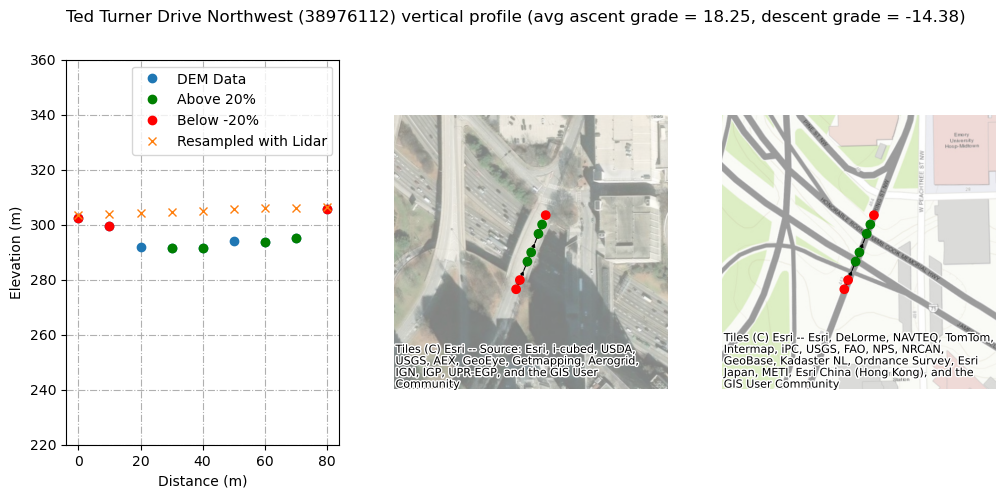

In [9]:
import random
from importlib import reload
reload(elevation_tools)
#pick some examples to visaulize here
# linkid = random.choice(with_lidar) # 
linkid = 38976112
grade_threshold = 20
elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,one_off=True)